In [1]:
!export HF_HUB_ENABLE_HF_TRANSFER=1
%load_ext autoreload
%autoreload 2

from functools import cache
import json
from io import BytesIO
from pathlib import Path

import torch
from diffusers import FluxPipeline, FluxTransformer2DModel, GGUFQuantizationConfig
from google import genai
from google.genai import types as gtypes
from IPython.display import Image as IPImage
from PIL import Image

from ai_storyteller.utils.env_utils import get_env_var

DATA_PATH = Path("../../data")
print(f"Data path: {DATA_PATH}")

gemini_api_key = get_env_var("GEMINI_API_KEY")
client = genai.Client(api_key=gemini_api_key)

Data path: ../../data
Found GEMINI_API_KEY using strategy: _get_from_env


# Get story

In [2]:
with DATA_PATH.joinpath("stories/tea/story.json").open() as f:
    story = json.load(f)
story

{'title': '珍珠奶茶歷險記',
 'pages': {'cover': {'text': '', 'img': 'cover.png'},
  '1': {'text': '在一個涼爽的冰箱裡，住著快樂的珍珠奶茶三兄弟：波霸、珍珠和布丁。\n他們每天在冰涼的家裡玩耍，吸管是他們的溜滑梯，冰塊是他們的堡壘。\n\n有一天，冰箱門突然打開了！\n一個巨大的人影靠近，口渴的聲音說：「好想喝點冰的！」',
   'img': '1.png'},
  '2': {'text': '「是人類！」三兄弟驚慌失措。\n一隻大手伸了進來，慢慢地靠近他們。\n\n勇敢的波霸說：「快躲到牛奶盒後面！」\n聰明的珍珠想起：「人類不喜歡過期的飲料，我們滾到後面去！」\n布丁嚇得滾來滾去。',
   'img': '2.png'},
  '3': {'text': '他們團結合作，滾到了巨大的牛奶盒後面，屏住呼吸。\n大手抓走了旁邊的果汁。\n\n冰箱門關上了，再次恢復平靜。\n三兄弟鬆了一口氣，互相擊掌（用吸管）。\n「我們安全了！」他們小聲歡呼，慶祝又一次躲過了口渴的人類。',
   'img': '3.png'}}}

In [ ]:
content = [p_dict["text"] for p_name, p_dict in story["pages"].items()]
content = [c for c in content if c]
content = [f"Page {i + 1}\n{c}" for i, c in enumerate(content)]
content = "\n\n".join(content)
print(content)

Page 1
在一個涼爽的冰箱裡，住著快樂的珍珠奶茶三兄弟：波霸、珍珠和布丁。
他們每天在冰涼的家裡玩耍，吸管是他們的溜滑梯，冰塊是他們的堡壘。

有一天，冰箱門突然打開了！
一個巨大的人影靠近，口渴的聲音說：「好想喝點冰的！」

Page 2
「是人類！」三兄弟驚慌失措。
一隻大手伸了進來，慢慢地靠近他們。

勇敢的波霸說：「快躲到牛奶盒後面！」
聰明的珍珠想起：「人類不喜歡過期的飲料，我們滾到後面去！」
布丁嚇得滾來滾去。

Page 3
他們團結合作，滾到了巨大的牛奶盒後面，屏住呼吸。
大手抓走了旁邊的果汁。

冰箱門關上了，再次恢復平靜。
三兄弟鬆了一口氣，互相擊掌（用吸管）。
「我們安全了！」他們小聲歡呼，慶祝又一次躲過了口渴的人類。


# Create a storyboard 

In [4]:
create_storyboard_prompt = """\
我想要根據以下故事製作一個影片。請幫我為一個文字轉影片模型建立一個情節串連圖。請依循以下準則：
1. 每個場景的提示語應清晰簡潔。
2. 影片總長度為 {sec} 秒。所有場景的內容應共同構成此長度，並自然流暢地呈現。
3. 情節串連圖中，**切勿為個別場景標註具體的開始或結束時間**。
4. 除情節串連圖外，不輸出任何其他內容。

內容：
{content}
"""

filled_prompt = create_storyboard_prompt.format(
    sec=8,
    content=content,
)
print(filled_prompt)

我想要根據以下故事製作一個影片。請幫我為一個文字轉影片模型建立一個情節串連圖。請依循以下準則：
1. 每個場景的提示語應清晰簡潔。
2. 影片總長度為 8 秒。所有場景的內容應共同構成此長度，並自然流暢地呈現。
3. 情節串連圖中，**切勿為個別場景標註具體的開始或結束時間**。
4. 除情節串連圖外，不輸出任何其他內容。

內容：
Page 1
在一個涼爽的冰箱裡，住著快樂的珍珠奶茶三兄弟：波霸、珍珠和布丁。
他們每天在冰涼的家裡玩耍，吸管是他們的溜滑梯，冰塊是他們的堡壘。

有一天，冰箱門突然打開了！
一個巨大的人影靠近，口渴的聲音說：「好想喝點冰的！」

Page 2
「是人類！」三兄弟驚慌失措。
一隻大手伸了進來，慢慢地靠近他們。

勇敢的波霸說：「快躲到牛奶盒後面！」
聰明的珍珠想起：「人類不喜歡過期的飲料，我們滾到後面去！」
布丁嚇得滾來滾去。

Page 3
他們團結合作，滾到了巨大的牛奶盒後面，屏住呼吸。
大手抓走了旁邊的果汁。

冰箱門關上了，再次恢復平靜。
三兄弟鬆了一口氣，互相擊掌（用吸管）。
「我們安全了！」他們小聲歡呼，慶祝又一次躲過了口渴的人類。



## Generate

In [ ]:
res = client.models.generate_content(model="gemini-2.0-flash", contents=[filled_prompt])
print(res.text)

1. **冰冷的冰箱內部：波霸、珍珠和布丁三個珍珠奶茶快樂地玩耍，吸管當溜滑梯，冰塊當堡壘。**
2. **冰箱門突然打開：巨大的人影靠近，一個模糊的臉龐說：「好想喝點冰的！」**
3. **波霸、珍珠、布丁驚恐地看著伸過來的大手，他們擠在一起。**
4. **三兄弟滾動著躲到牛奶盒後面，屏住呼吸。**
5. **大手抓走了旁邊的果汁，冰箱門關上。**
6. **三兄弟鬆了一口氣，用吸管互相擊掌慶祝。**



# Gemini

## Text to image

I will generate a 3D rendering of a whimsical scene featuring a pink pig with feathery white wings and a dapper black top hat soaring through the air. Below, a vibrant, futuristic city will be depicted with sleek, silver buildings interspersed with lush green parks and trees, all under a bright, sunny sky, conveying a sense of cheerful utopia.



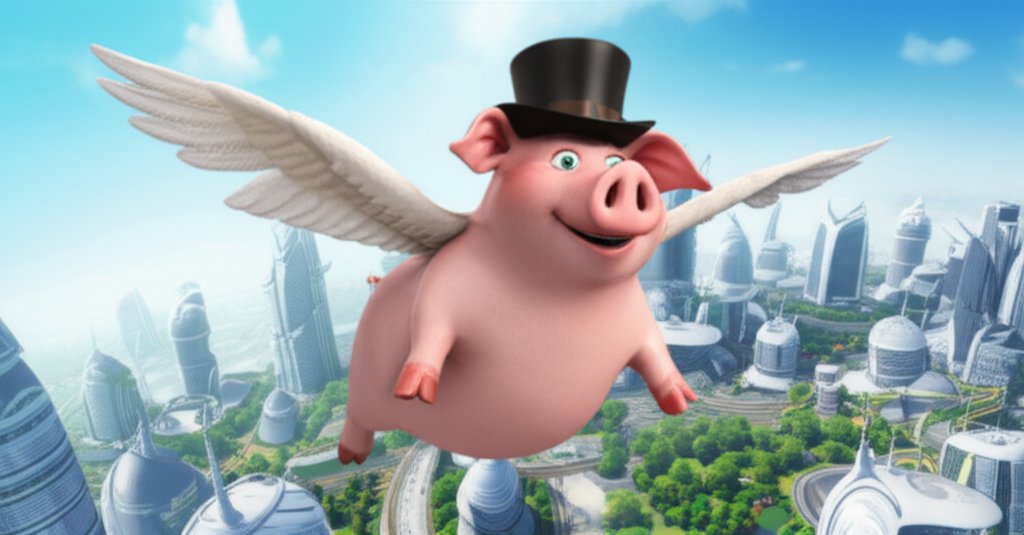

In [2]:
contents = (
    "Hi, can you create a 3d rendered image of a pig "
    "with wings and a top hat flying over a happy "
    "futuristic scifi city with lots of greenery?"
)

response = client.models.generate_content(
    model="gemini-2.0-flash-exp-image-generation",
    contents=contents,
    config=gtypes.GenerateContentConfig(response_modalities=["TEXT", "IMAGE"]),
)

for part in response.candidates[0].content.parts:
    if part.text is not None:
        print(part.text)
    elif part.inline_data is not None:
        image = Image.open(BytesIO((part.inline_data.data)))
        image.save("gemini-native-image.png")
        display(IPImage(filename="gemini-native-image.png"))

## Image editing

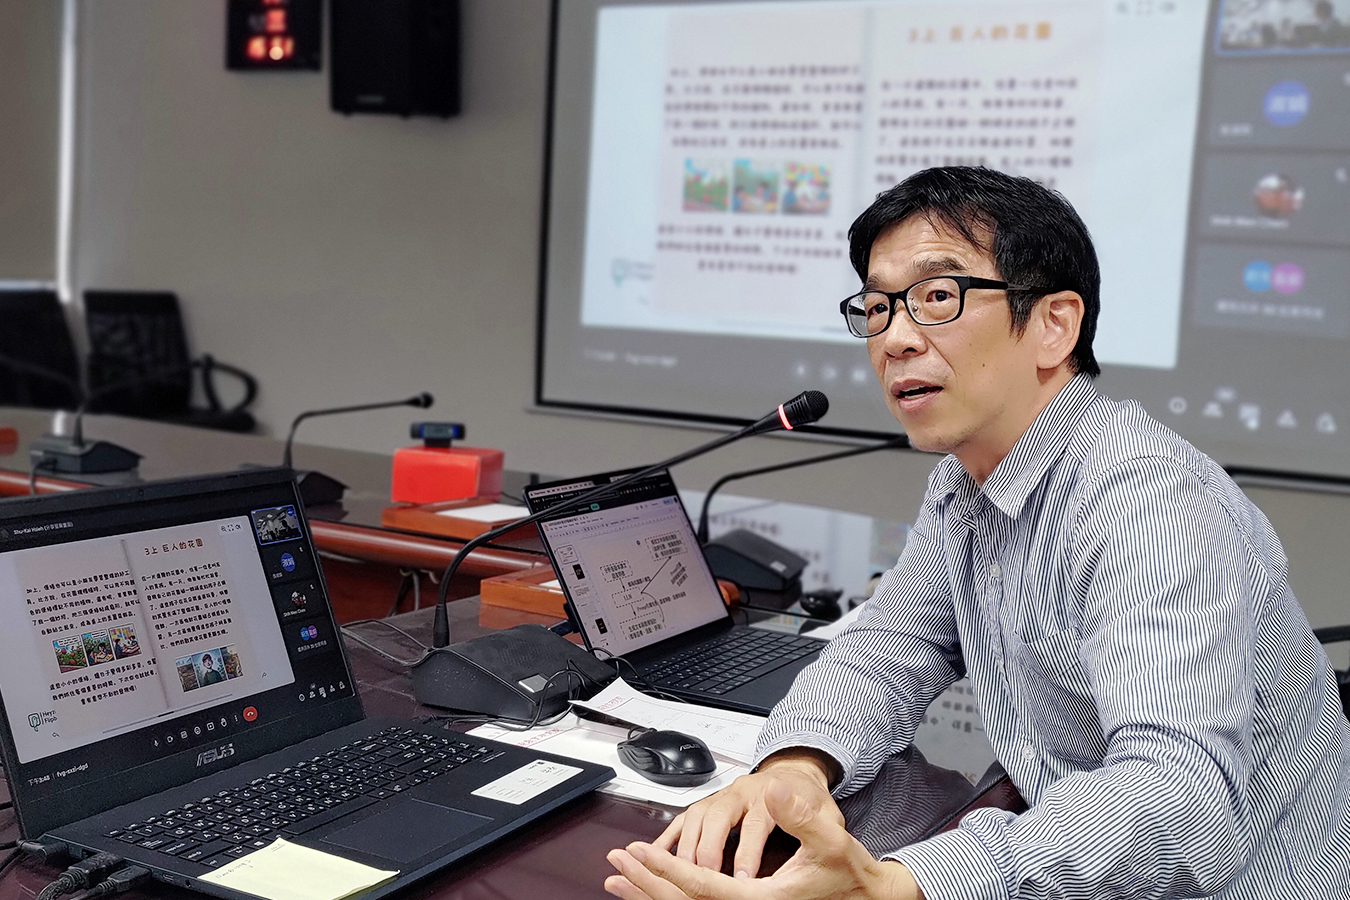

In [2]:
image = Image.open(DATA_PATH / "image_generation/img/shukai2.jpg")
image

Compare the outputs using `shukai.jpg` and `shukai2.jpg`

A fluffy white llama with curious eyes will stand comfortably next to the man in the green shirt, both looking towards the viewer against a plain background, maintaining the original lighting and perspective.



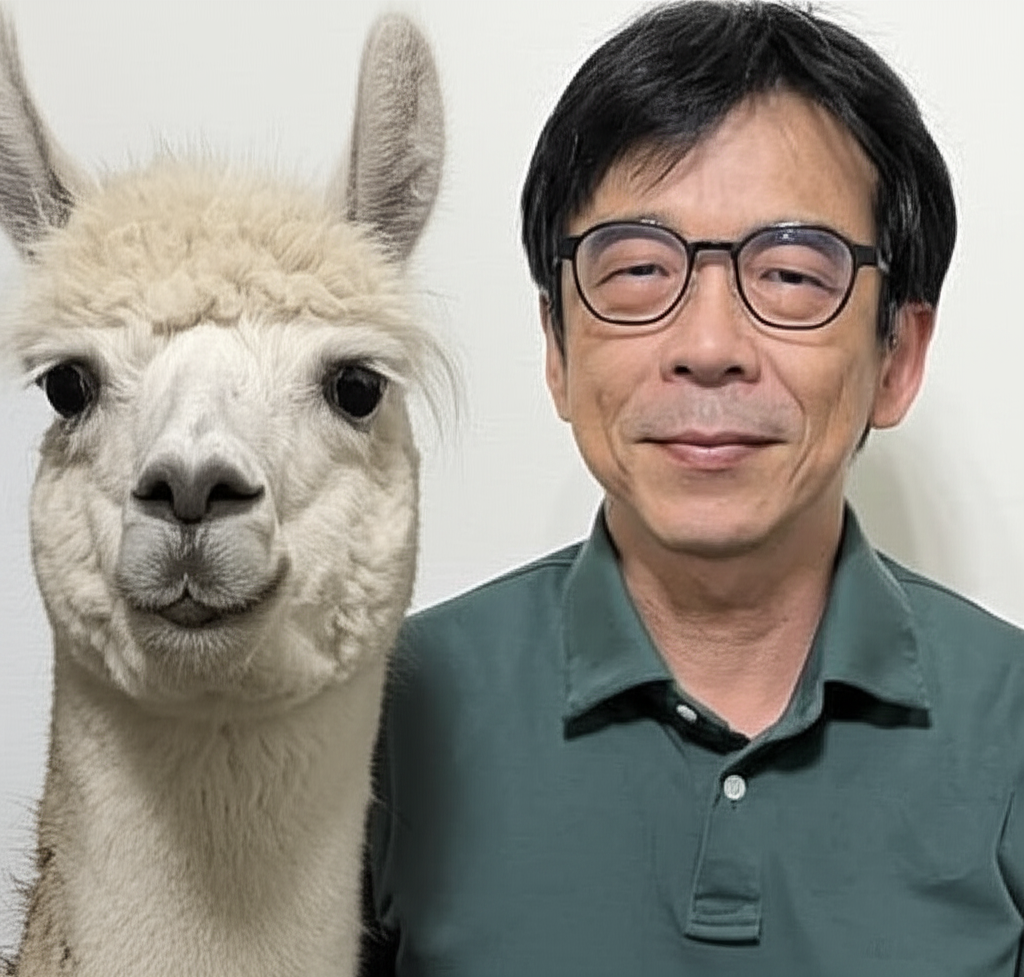

In [ ]:
image = Image.open(DATA_PATH / "image_generation/img/shukai.jpg")
# image = Image.open('../../data/image_generation/img/shukai2.jpg')

client = genai.Client(api_key=gemini_api_key)

text_input = """\
Hi, This is a picture of me.
Can you add a llama next to me?
"""

response = client.models.generate_content(
    model="gemini-2.0-flash-exp-image-generation",
    contents=[text_input, image],
    config=gtypes.GenerateContentConfig(response_modalities=["TEXT", "IMAGE"]),
)

for part in response.candidates[0].content.parts:
    if part.text is not None:
        print(part.text)
    elif part.inline_data is not None:
        image = Image.open(BytesIO(part.inline_data.data))
        display(image)

## Combining images

I will add your likeness into the charming children's story scene. You will be depicted standing in the doorway, rendered in the same cute, cartoonish style as the bubble tea, pudding, and mochi characters amidst the sugar cubes.




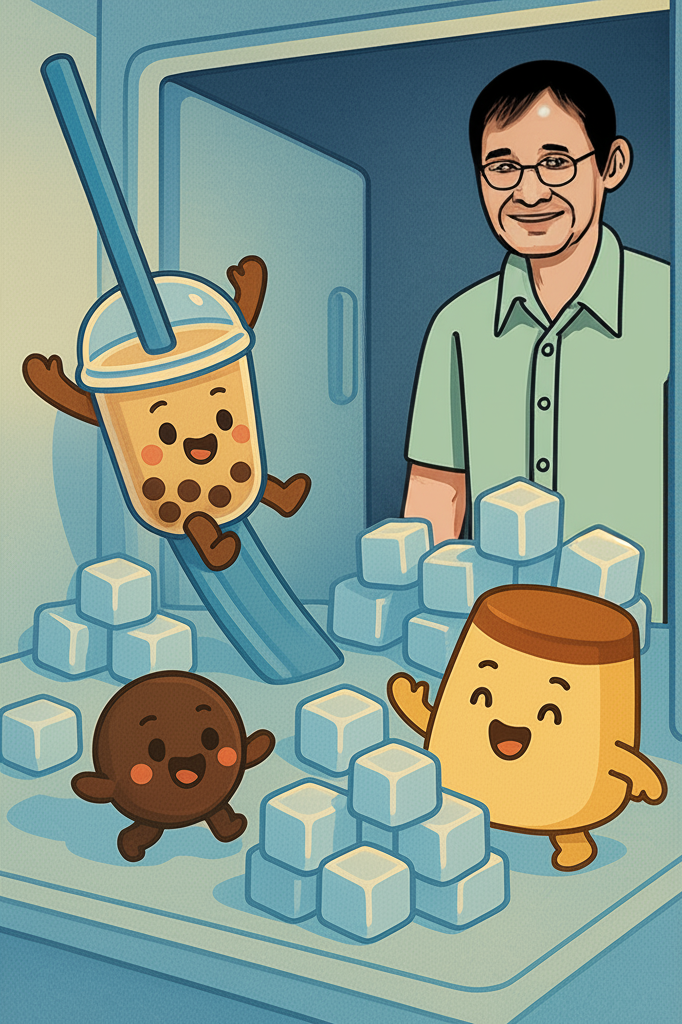

In [ ]:
person_img = Image.open(DATA_PATH / "image_generation/img/shukai.jpg")
story_img = Image.open(DATA_PATH / "stories/tea/img/1.png")

client = genai.Client(api_key=gemini_api_key)

text_input = """\
The first picture is me. The second picture is a scene from a children's story.
Can you add me to the scene in the second picture? Make sure that I am properly integrated into the scene using the same art style as the second picture.
"""
response = client.models.generate_content(
    model="gemini-2.0-flash-exp-image-generation",
    contents=[text_input, person_img, story_img],
    config=gtypes.GenerateContentConfig(response_modalities=["TEXT", "IMAGE"]),
)

for part in response.candidates[0].content.parts:
    if part.text is not None:
        print(part.text)
    elif part.inline_data is not None:
        image = Image.open(BytesIO(part.inline_data.data))
        display(image)

# Hugging Face

In [3]:
@cache
def load_flux_pipeline(ckpt_path: str = "https://huggingface.co/city96/FLUX.1-dev-gguf/blob/main/flux1-dev-Q5_K_S.gguf") -> FluxPipeline:
    # ckpt_path = "https://huggingface.co/city96/FLUX.1-dev-gguf/blob/main/flux1-dev-Q4_K_S.gguf"
    transformer = FluxTransformer2DModel.from_single_file(
    ckpt_path,
    quantization_config=GGUFQuantizationConfig(compute_dtype=torch.bfloat16),
    torch_dtype=torch.bfloat16,
    )

    pipeline = FluxPipeline.from_pretrained(
        "black-forest-labs/FLUX.1-dev",
        transformer=transformer,
        torch_dtype=torch.bfloat16,
    )

    pipeline.enable_model_cpu_offload()

    return pipeline

pipe = load_flux_pipeline()

flux1-dev-Q5_K_S.gguf:   0%|          | 0.00/8.29G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['of field, focusing sharply on the cheese pull, chicken feet, and blue cheese, with a softly blurred, rustic wooden background. the overall mood is surprisingly appetizing and high - end.']


  0%|          | 0/50 [00:00<?, ?it/s]

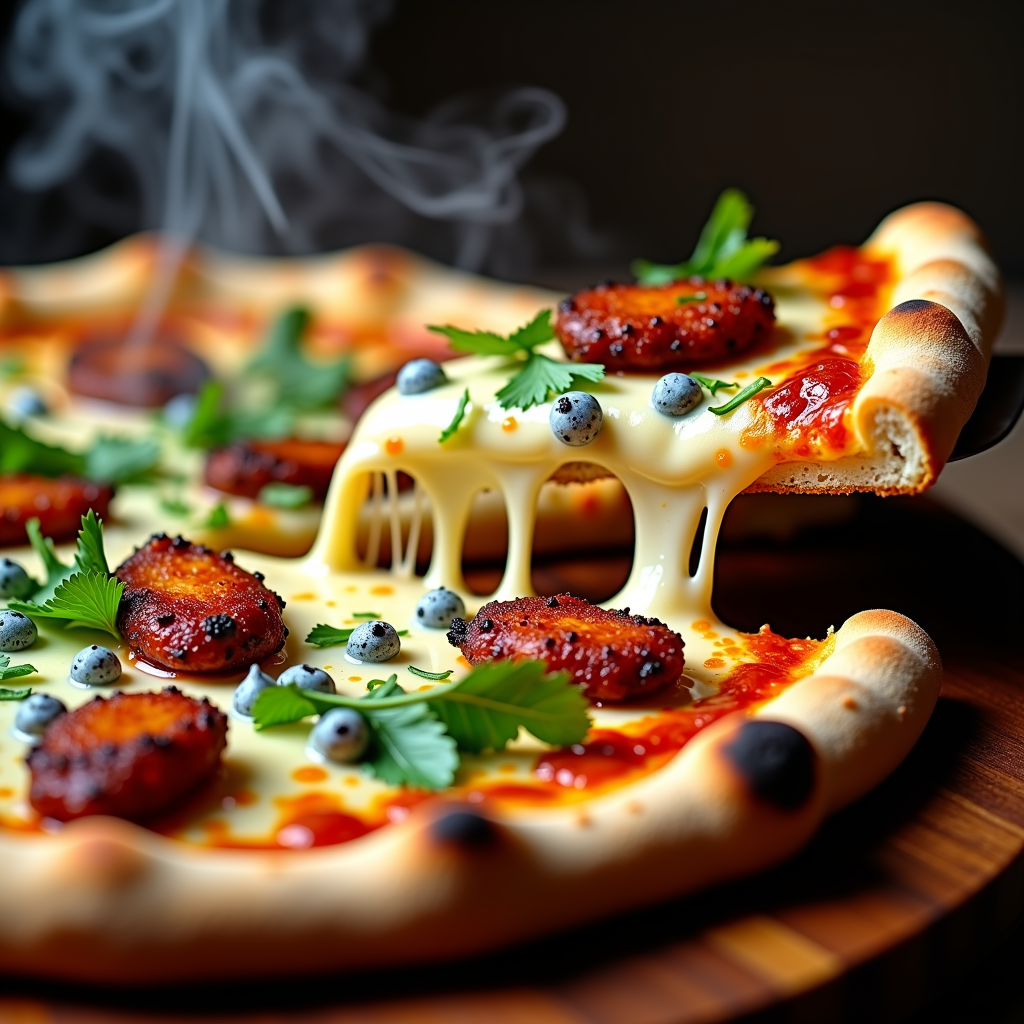

In [ ]:
prompt = "Gourmet food photography advertisement. A close-up, dramatically lit shot of a freshly baked artisan pizza with a golden, bubbly crust. The unconventional toppings: crispy, glazed chicken feet, artfully arranged among melted mozzarella, generous chunks of pungent blue cheese, and copious amounts of fresh cilantro. An epic cheese pull stretches from a lifted slice. Steam rises gently. Shallow depth of field, focusing sharply on the cheese pull, chicken feet, and blue cheese, with a softly blurred, rustic wooden background. The overall mood is surprisingly appetizing and high-end."
guidance_scale = 5.0
num_inference_steps = 15
save_path = f"flux_zh_pizza_guidance-{guidance_scale}_infersteps-{num_inference_steps}.png"

images = pipe(
    prompt=prompt,
    num_inference_steps=num_inference_steps,
    guidance_scale=guidance_scale,
    height=1024,
    width=1024,
    generator=torch.Generator("cuda").manual_seed(42),
).images[0]

images.save(save_path)
images

# Exercise

## Things to explore
* **world knowledge**:
* **cultural relevance**:
* **implicit bias**:
* **prompt adherence**:
* https://www.theverge.com/2024/2/21/24079371/google-ai-gemini-generative-inaccurate-historical

AI 圖像生成練習：宣傳活動與模型分析練習目標運用 AI 圖像生成工具，為自選主題設計宣傳圖像。分析 AI 表現，創作風格一致的宣傳素材組合。核心概念「如果請他們宣傳一個產品（或人？影劇？）做出宣傳影片和形象照呢...可以讓他們想辦法把生成圖片、生成影片用成同一個系列風格的，讓他們產出完整的宣傳set之類的。感覺這樣同時可以保留創意（他們可以自己決定要宣傳什麼東西），也比較有既定的目標（要宣傳推銷、吸睛）。」註：本次練習專注於圖像生成。任務概覽選定主題: 決定宣傳對象（產品、人物、作品等）。構思概念: 思考宣傳訊息、目標受眾與風格。生成圖像: 使用 AI 工具創作 2-3 張宣傳圖像。分析表現: 依「探索重點」指引，檢視 AI 能力。建議工具鼓勵嘗試以下 AI 圖像生成工具:GeminiSora (註：雖以影片聞名，可探索其圖像理解或多模態能力)Flux其他您可用的工具。探索重點 (分析並比較優缺點)反思並準備討論 AI 模型在以下方面的表現：探索重點 1：世界知識定義: 模型對概念、物體、關係的理解程度，尤其對冷僻內容的處理。建議測試方式: 例如，您可以在提示語中加入特定或較不常見的元素，觀察模型的回應。範例:參考 ai_image_prompts_for_exercise 文件：提示語1的「貓咪與巨大榴槤」提示語2的「客家花布」模型如何處理？探索重點 2：文化關聯性定義: 模型對文化細節、符號、美學的理解與呈現。建議測試方式: 若主題具文化背景，不妨嘗試將其融入提示語，看看模型如何詮釋。範例:參考 ai_image_prompts_for_exercise 文件提示語2：「台灣茶職人」與「客家花布」。AI 詮釋是否真實？中英文提示語是否有差異？探索重點 3：內隱偏見定義: 生成圖像是否展現關於性別、種族等的偏見。建議觀察點: 當宣傳材料中包含人物時，可以留意其呈現方式，思考是否反映了某些傾向。範例:參考 ai_image_prompts_for_exercise 文件提示語2：「年輕、充滿活力的台灣茶職人」。觀察其性別、種族特徵，以及「非傳統髮色」的影響。探索重點 4：提示語遵從度定義: 模型遵循指示的程度；是否整合所有細節，或有忽略/誤解。建議測試方式: 您可以設計包含多個具體細節的提示語，以此測試模型對指示的遵循程度。範例:參考 ai_image_prompts_for_exercise 文件中各提示語的多重細節：提示語1的拍攝角度、光線提示語3的配料與效果AI 成功呈現哪些？遺漏哪些？探索重點 5：圖像內文字生成能力定義: 模型在圖像中生成清晰、準確、風格一致文字的能力。建議測試方式: 不妨嘗試在宣傳圖像中加入簡短文字，如品牌名稱或標語，以評估其文字生成能力。範例:參考 ai_image_prompts_for_exercise 文件提示語2或3，嘗試加入品牌名或標語。觀察文字清晰度、正確性及風格。成果交付／分享 (課程結束時)準備簡短分享：1-2 張最滿意的宣傳圖像。主題與宣傳核心概念。至少兩項「探索重點」的觀察。結語本練習旨在培養創意與批判性思維。祝實驗愉快，觀察敏銳！

# Video

In [ ]:
from diffusers import GGUFQuantizationConfig, LTXPipeline, LTXVideoTransformer3DModel
from diffusers.utils import export_to_video
from IPython.display import Video

ckpt_path = "https://huggingface.co/city96/LTX-Video-gguf/blob/main/ltx-video-2b-v0.9-Q3_K_S.gguf"
transformer = LTXVideoTransformer3DModel.from_single_file(
    ckpt_path,
    quantization_config=GGUFQuantizationConfig(compute_dtype=torch.bfloat16),
    torch_dtype=torch.bfloat16,
)
pipe = LTXPipeline.from_pretrained(
    "Lightricks/LTX-Video",
    transformer=transformer,
    torch_dtype=torch.bfloat16,
)
# pipe.to("cuda")
pipe.enable_model_cpu_offload()


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

'output_gguf_ltx.mp4'

In [4]:
prompt = "Dynamic close-up shot of a fresh pizza pie with comically large chunks of tofu, dripping with cheese, in front of a pizza kiln, with a smooth zoom. Dramatic studio lighting, rule of thirds, warm, inviting colors, shallow depth of field. Then a close-up shot of someone taking a slice, then taking an appetizing bite with a huge cheese pull. Ultra HD, professional cinematography, commercial style, invigorating and appetizing."
negative_prompt = "worst quality, inconsistent motion, blurry, jittery, distorted"

video = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    width=640,
    height=320,
    num_frames=193,
    num_inference_steps=50,
).frames[0]
export_to_video(video, "output_gguf_ltx.mp4", fps=24)
Video("output_gguf_ltx.mp4", width=640, height=320)

  0%|          | 0/50 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


  0%|          | 0/15 [00:00<?, ?it/s]

# Hugging Face Inference Providers

* [Table of Inference Providers partners](https://huggingface.co/docs/inference-providers/en/index#partners)

# GGUF

* [Diffusers documentation about GGUF](https://huggingface.co/docs/diffusers/v0.33.1/en/quantization/gguf#supported-quantization-types)
* [Overview of GGUF quantization methods | Reddit](https://www.reddit.com/r/LocalLLaMA/comments/1ba55rj/overview_of_gguf_quantization_methods/)
* [Official GGUF documentation](https://github.com/ggml-org/ggml/blob/master/docs/gguf.md)